In [53]:
from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, LearningCurveDisplay, learning_curve, validation_curve
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score
)


from utils import get_data, get_df_details, plot_distrb, make_confusion_matrix

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [54]:
X, y, metadata, variables = get_data('dry_bean_dataset')

In [55]:
y.value_counts(normalize=True)

Class   
DERMASON    0.260525
SIRA        0.193667
SEKER       0.148924
HOROZ       0.141650
CALI        0.119756
BARBUNYA    0.097127
BOMBAY      0.038351
Name: proportion, dtype: float64

In [56]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [57]:
idx = variables['type'].isin(['Integer', 'Continuous'])
num_cols = variables.loc[idx, 'name']
num_cols = num_cols.loc[~num_cols.isin(y.columns.tolist())]
num_cols

0                Area
1           Perimeter
2     MajorAxisLength
3     MinorAxisLength
4         AspectRatio
5        Eccentricity
6          ConvexArea
7       EquivDiameter
8              Extent
9            Solidity
10          Roundness
11        Compactness
12       ShapeFactor1
13       ShapeFactor2
14       ShapeFactor3
15       ShapeFactor4
Name: name, dtype: object

In [58]:
idx = variables['type'].isin(['Binary', 'Categorical'])
cat_cols = variables.loc[idx, 'name']
cat_cols = cat_cols.loc[~cat_cols.isin(y.columns)]
cat_cols

Series([], Name: name, dtype: object)

# Train the Expectation Maximisation

In [59]:
RANDOM_STATE = 42
# N_FOLDS = 5
N_JOBS = -1
VERBOSE = 4


# Use minmax scaler for simplicity, scalability, avoids assumption of distribution and there are no outliers in data
num_pipeline = Pipeline(steps=[
    # ('scale', MinMaxScaler())
    ('scale', StandardScaler())
])
# cat_pipeline = Pipeline(steps=[
#     ('one-hot', OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse=False))
# ])

col_trans = ColumnTransformer(
    transformers=[
        ('num_pipeline', num_pipeline, num_cols),
        # ('cat_pipeline', cat_pipeline, cat_cols)
        ],
    remainder='drop',
    n_jobs=N_JOBS)

# For KMeans use the default algo, max_iterations, init='k-means++'
# clus = GaussianMixture(n_init=100, init_params='k-means++', random_state=RANDOM_STATE, covariance_type='full')
clus = GaussianMixture(random_state=RANDOM_STATE, n_init=100)
clus_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clus)
])


In [60]:
X_train.values

array([[4.21420000e+04, 7.41324000e+02, 2.60523582e+02, ...,
        2.38327400e-03, 7.90553345e-01, 9.99221541e-01],
       [5.38660000e+04, 9.61806000e+02, 3.87117925e+02, ...,
        9.28506000e-04, 4.57655075e-01, 9.95744227e-01],
       [7.43120000e+04, 1.02521100e+03, 3.90615917e+02, ...,
        1.24683500e-03, 6.20110658e-01, 9.93503386e-01],
       ...,
       [6.58060000e+04, 1.04286300e+03, 3.61126192e+02, ...,
        1.39729600e-03, 6.42477073e-01, 9.88559754e-01],
       [5.35050000e+04, 9.21825000e+02, 3.75316539e+02, ...,
        1.01204800e-03, 4.83625377e-01, 9.91770957e-01],
       [1.70723000e+05, 1.59910500e+03, 6.21010408e+02, ...,
        7.12845000e-04, 5.63643359e-01, 9.91139890e-01]])

In [61]:
X_train.values.shape

(10888, 16)

In [63]:
clus_pipeline.set_params(model__n_components=10)
clus_pipeline.fit(X_train)

KeyboardInterrupt: 

In [ ]:
clus_pipeline.named_steps['model'].bic(X_train)

In [40]:
clus_labels = clus_pipeline.named_steps['model'].predict(X_train.values)
clus_labels

array([14, 14, 14, ..., 14, 14, 14], dtype=int64)

In [41]:
sil_score = silhouette_score(X_train.values, clus_labels)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [18]:
results = {}
for n_components in range(2, 20):
    print(f"---------- n_components: {n_components} ----------")
    clus_pipeline.set_params(model__n_components=n_components)
    clus_pipeline.fit(X_train)
    
    clus_labels = clus_pipeline.named_steps['model'].predict(X_train)
    sil_score = silhouette_score(X_train, clus_labels)
    
    results[n_components] = {'inertia': clus_pipeline.named_steps['model'].inertia_,
                           'sil_score': sil_score}

---------- n_components: 2 ----------


C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
print(results)

<Axes: title={'center': 'Elbow plot'}, xlabel='n_clusters'>

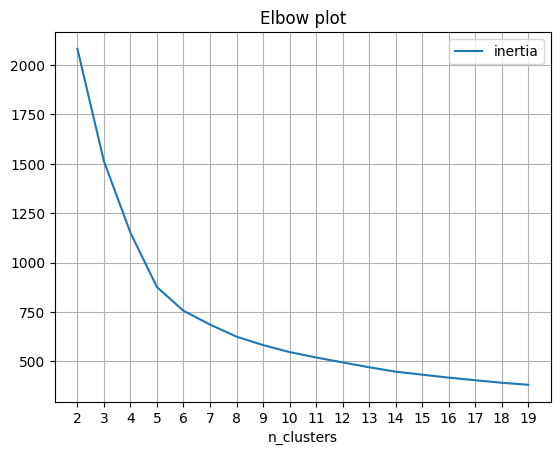

In [90]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_components', 'inertia', 'sil_score']
results_df.plot(x='n_components', y='inertia',title='Elbow plot', xticks=results_df['n_clusters'], grid=True)

<Axes: title={'center': 'Silhoutte Score'}, xlabel='n_clusters'>

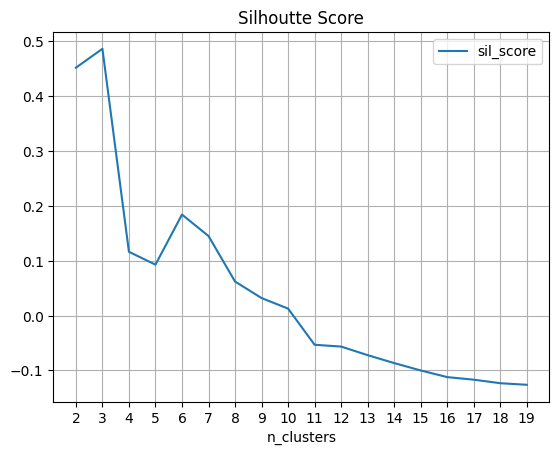

In [92]:
results_df.plot(x='n_components', y='sil_score',title='Silhoutte Score', xticks=results_df['n_clusters'], grid=True)

# Tune the KMeans

In [67]:
# # https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/
# # 

# cv_scores = []

# grid_params = {
#         'n_clusters': {'model__n_clusters': np.arange(2,21)}, 
#         'n_init': {'model__n_init': np.arange(5, 55, 5)},
#         'init': {'model__init': ['k-means++', 'random']},
#         'max_iter': {'model__max_iter': np.arange(100, 1000, 100)},
#     }
# for key, grid_param in grid_params.items():
#     print('------------------', key, '------------------')
    
#     gs = GridSearchCV(clus_pipeline, grid_param, 
#                       cv=N_FOLDS, scoring=silhouette_score, n_jobs=N_JOBS, verbose=VERBOSE, return_train_score=True,
#                      refit=True)
#     gs.fit(X_train)

#     cv_scores.append(pd.DataFrame({'param': [key]*len(gs.cv_results_['mean_test_score']),
#                                    'value': gs.cv_results_[f'param_{list(grid_param.keys())[0]}'],
#                                    'mean_test_score': gs.cv_results_['mean_test_score'],
#                                    'mean_train_score': gs.cv_results_['mean_train_score']}))

# cv_scores = pd.concat(cv_scores)

------------------ n_clusters ------------------
Fitting 5 folds for each of 19 candidates, totalling 95 fits


C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
  warnings.warn(
C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]
  warnings.warn(


------------------ n_init ------------------
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


------------------ init ------------------
Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(
C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the train scores are non-finite: [nan nan]
  warnings.warn(


------------------ max_iter ------------------
Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(


C:\Users\pavan\anaconda3\envs\ml\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


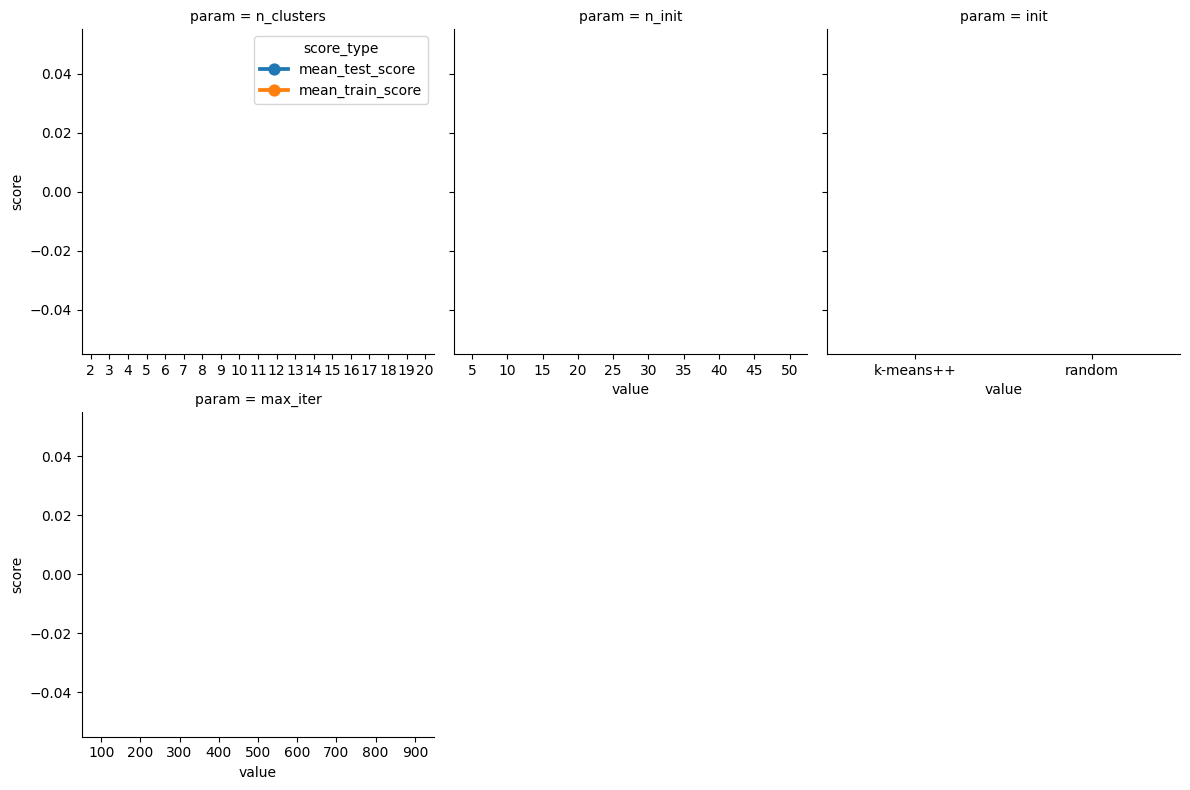

In [68]:
# cv_scores_melt = cv_scores.melt(id_vars=['param', 'value'], value_vars=['mean_test_score', 'mean_train_score'], var_name='score_type', value_name='score')
# sns.FacetGrid(cv_scores_melt, col='param', hue='score_type', col_wrap=3, height=4, sharex=False, legend_out=False).map(sns.pointplot, 'value', 'score').add_legend()

In [ ]:
# grid_params = {
#         'model__n_neighbors': np.arange(35, 50, 5), 
#         'model__metric':['minkowski', 'manhattan', 'euclidean'],
#     }

    
# gs = GridSearchCV(clf_pipeline, grid_params, 
#                     cv=N_FOLDS, scoring=SCORING, n_jobs=N_JOBS, verbose=VERBOSE, return_train_score=True)
# gs.fit(X_train, y_train.values.ravel())

# print("Best Score of train set: "+str(gs.best_score_))
# print("Best parameter set: "+str(gs.best_params_))
# print("Test Score: "+str(gs.score(X_test,y_test)))

In [ ]:
gs.best_estimator_['model']

In [ ]:
import joblib
joblib.dump(value=gs, filename='./model/kmeans_dry_bean_ppl.pkl', compress=True)
joblib.dump(value=gs.best_estimator_, filename='./model/kmeans_dry_bean_ppl.pkl', compress=True)

In [ ]:
# Plot learning curve of the best model from grid search
train_size_abs, train_scores, test_scores = \
    learning_curve(gs.best_estimator_, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=N_FOLDS, n_jobs=N_JOBS, scoring=SCORING, verbose=VERBOSE)

In [ ]:
plot_df = pd.DataFrame({'train_size_abs': train_size_abs, 
                        'mean_train_scores': np.mean(train_scores, axis=1), 
                        'mean_test_scores': np.mean(test_scores, axis=1)})
plot_df = plot_df.melt(id_vars='train_size_abs', value_vars=['mean_train_scores', 'mean_test_scores'])
sns.pointplot(plot_df, x='train_size_abs',y ='value', hue='variable')

In [ ]:
# Get the score of the best model on test

# gs.best_estimator_ is the best model found by GridSearchCV
y_test_predictions = gs.predict(X_test)
# Generate confusion matrix for the predictions from the best model
conf_matrix = confusion_matrix(y_test, y_test_predictions)

make_confusion_matrix(conf_matrix, group_names=['True Neg','False Pos','False Neg','True Pos'], categories=['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'], cmap='Blues')

In [ ]:
# target_names=target_names
print(classification_report(y_test, y_test_predictions))